In [1]:
from typing import Dict
from IPython import display
import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from copy import deepcopy

import seaborn as sns
sns.set_theme()

from src.deep_hedging.DeepHedge import DeepHedgeConfig, DeepHedge
from src.deep_hedging.DeepHedgeTrainer import DeepHedgeTrainer, DeepHedgeTrainerConfig
from src.deep_hedging.StrategyNet import StrategyNetConfig
from src.deep_hedging.objectives.HedgeObjective import MeanVariance, Entropy, StableEntropy, Std
from src.derivative.EuropeanCallOption import EuropeanCallOption
from src.gan.RobustDhGan import RobustDhGan
from src.generator.BlackScholesCoefficient import BlackScholesCoefficientConfig, BlackScholesDriftCoefficient, BlackScholesDiffusionCoefficient
from src.generator.SdeGenerator import GeneratorConfig, SdeGenerator
from src.generator.SdeGeneratorTrainer import SdeGeneratorTrainerConfig
from src.penalty.Augmentations import LeadLag, AddTimeComponent
from src.penalty.SigWassersteinMetric import SignatureConfig, SigWassersteinMetric
from src.penalty.CompareVolatility import CompareVolatility, VolatilityComparisonConfig
from src.util.TimeUtil import UniformTimeDiscretization
from src.util.processes.BlackScholesGenerator import BlackScholesGenerator
from src.util.processes.BrownianMotionGenerator import BrownianMotionGenerator
from src.util.processes.BlackScholesGenerator import BlackScholesParameterSet, BlackScholesGenerator
from src.util.torch_util.AdapterUtil import Adapter, AdapterList, SelectDimensions, ConvertToIncrements
from src.util.torch_util.TrainingUtil import TrainerConfig
from src.generator.SdeGeneratorTrainer import SdeGeneratorTrainer
from src.util.torch_util.CallbackUtil import PrintMetrics, PrintGeneratorParameters, PrintEmptyLine
from src.util.VisualizationUtil import QuantityLogger
from src.util.torch_util.TrainingUtil import TrainerConfig, PbarOption, gen_factory
from src.util.ray_util.TqdmUtil import to_limited_iterator, to_iterator
from src.util.PushOverUtil import notify
from src.config import DEVICE

In [2]:
import ray
ray.init()

2023-04-24 14:33:23,975	INFO worker.py:1518 -- Started a local Ray instance.


Python version:,3.8.0
Ray version:,2.0.1


In [3]:
trading_freq: int = 5
penalty_scale: float = 75
uncertainty_aversion: float = 130

In [4]:
target_folder = f'resources/network-states/test_bs_new/ua{uncertainty_aversion:03}/tf_{trading_freq:02}'
add_on = f'/v_cv_{penalty_scale:03.0f}'
target_folder

'resources/network-states/test_bs_new/ua130/tf_05'

In [5]:
add_on

'/v_cv_075'

## Setup

In [5]:
bs_parameters = BlackScholesParameterSet(
    drift=0.0,
    sigma=0.2,
)
estimated_model = BlackScholesGenerator(
    drift=np.array([bs_parameters.drift]),
    sigma=np.array([bs_parameters.sigma]),
)

In [6]:
td = UniformTimeDiscretization(trading_freq * 1. / 255., 90 // trading_freq)
derivative = EuropeanCallOption(strike=1.0, time_discretization=td, price=0.0)

In [7]:
estimated_generator = estimated_model.provide_generator(
    initial_value=np.array([1.0]),
    times=td.times,
    random_number_generator=np.random.default_rng(1111),
)
reference_paths = estimated_generator(2**16)

In [8]:
pen_config = VolatilityComparisonConfig(td)
penalizer = CompareVolatility(reference_paths, pen_config, transform=lambda x: penalty_scale * x ** 2)

## Generator

In [9]:
coef_config = BlackScholesCoefficientConfig(
    BlackScholesParameterSet(drift=bs_parameters.drift, sigma=bs_parameters.sigma),
    initial_asset_price=1.0,
)
drift_coef, diffusion_coef = BlackScholesDriftCoefficient(coef_config), BlackScholesDiffusionCoefficient(coef_config)
gen_config = GeneratorConfig(td, drift_coef.get_initial_asset_price, drift_coef, diffusion_coef)
generator = SdeGenerator(generator_config=gen_config)

In [10]:
generator.drift.drift.requires_grad = False

In [11]:
noise_generator = BrownianMotionGenerator().provide_increment_generator(
    initial_value=np.zeros(1),
    times=td.times,
    random_number_generator=np.random.default_rng(4444),
)

## Deep Hedge

In [12]:
hedge_objective = MeanVariance(uncertainty_aversion)

In [13]:
deep_hedge = DeepHedge(
    DeepHedgeConfig(
        derivative=derivative,
        initial_information_value=torch.tensor([1.0], dtype=torch.float32, device=DEVICE),
        strategy_config=StrategyNetConfig(
            dim_of_information_process=1,
            dim_of_tradable_asset=1,
            number_of_layers=2,
            nodes_in_intermediate_layers=128,
        ),
    )
)

In [14]:
dh_trainer_config = DeepHedgeTrainerConfig(hedge_objective)
trainer_config = None
dh_trainer = DeepHedgeTrainer(dh=deep_hedge, config=dh_trainer_config, trainer_config=trainer_config)

In [15]:
sample_size = 2**16
batch_sizes_for_epoch = [2**8]*5 + [2**10]*5 + [2**12]*5 + [2**14]*5
to_increments = ConvertToIncrements()

In [16]:
for p in generator.parameters():
    p.requires_grad = False

In [17]:
try: 
    deep_hedge.load_state_dict(torch.load(f'{target_folder}/deep_hedge.pt'))
    dh_trainer.optimizer.load_state_dict(torch.load(f'{target_folder}/deep_hedge_optimizer.pt'))
except FileNotFoundError:
    m_list = []
    for batch_size in tqdm(batch_sizes_for_epoch):
        data = to_increments(generator(noise_generator(sample_size)))
        for batch in tqdm(torch.split(data, split_size_or_sections=batch_size, dim=0), leave=False):
            m_list.append(dh_trainer.step(batch))
    
    torch.save(deep_hedge.state_dict(), f'{target_folder}/deep_hedge.pt') 
    torch.save(dh_trainer.optimizer.state_dict(), f'{target_folder}/deep_hedge_optimizer.pt')
    
    np.save(f'{target_folder}/deep_hedge_training_metrics.npy', np.array([m.create_print_dict() for m in m_list])),

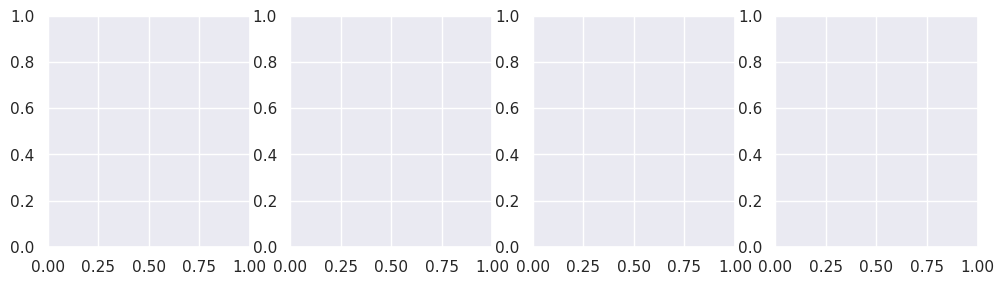

In [18]:
try:
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    for ax, beg in zip(axs, np.cumsum((0, 5*2**8, 5*2**6, 5*2**4))):
        ax.plot(np.log([m.hedge_loss.item() for m in m_list][beg:]))
    plt.tight_layout()
    plt.show()
except:
    pass

## Roubst Hedge GAN

In [19]:
active_generator = deepcopy(generator)
for p in active_generator.parameters():
    p.requires_grad = True

In [20]:
dht_config = DeepHedgeTrainerConfig(
    hedge_objective=hedge_objective,
    generation_adapters=AdapterList([ConvertToIncrements()]),
)
gt_config = SdeGeneratorTrainerConfig(penalizer=penalizer, penalization_adapters=AdapterList([]))
t_config = None
robust_dh_gan = RobustDhGan(
    dh=deepcopy(deep_hedge), 
    hedge_config=dht_config,
    gen=active_generator,
    gen_config=gt_config,
    trainer_config=t_config,
)
robust_dh_gan.dh_optimizer.load_state_dict(dh_trainer.optimizer.state_dict())

In [21]:
batch_sizes_for_epoch = 1000*[2**16]

In [22]:
try: 
    robust_dh_gan.dh.load_state_dict(torch.load(f'{target_folder+add_on}/rhgan_dh.pt'))
except FileNotFoundError:
    m_list = []
    for batch_size in tqdm(batch_sizes_for_epoch):
        data = noise_generator(sample_size)
        for batch in torch.split(data, split_size_or_sections=batch_size, dim=0):
            m_list.append(robust_dh_gan.step(batch))
    
    torch.save(robust_dh_gan.dh.state_dict(), f'{target_folder+add_on}/rhgan_dh.pt') 
    torch.save(robust_dh_gan.dh_optimizer.state_dict(), f'{target_folder+add_on}/rhgan_dh_optimizer.pt')
    torch.save(robust_dh_gan.gen_optimizer.state_dict(), f'{target_folder+add_on}/rhgan_gen_optimizer.pt')
    
    np.save(f'{target_folder+add_on}/rhgan_training_metrics.npy', np.array([m.create_print_dict() for m in m_list])),

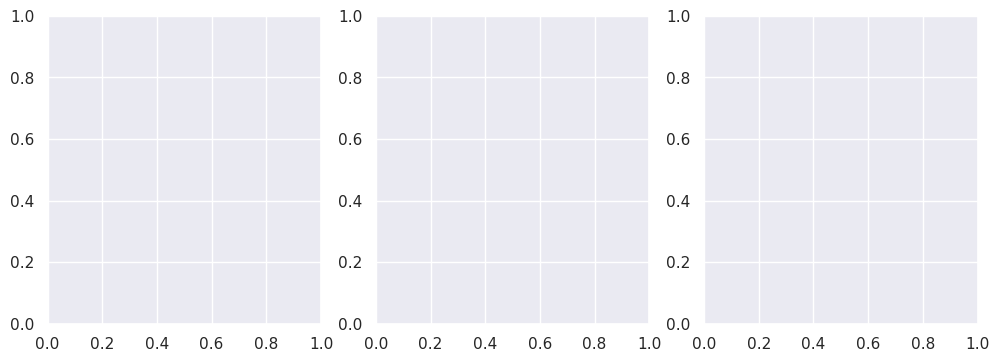

In [23]:
try:
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].plot(np.log([m.hedge_loss.item() for m in m_list]))
    axs[1].plot(-np.log([-m.generation_loss.item() for m in m_list]))
    axs[2].plot(np.log([m.penalty.item() for m in m_list]))
    plt.tight_layout()
    plt.show()
except:
    pass

## Post Deep Hedge Training

In [24]:
try: 
    deep_hedge.load_state_dict(torch.load(f'{target_folder}/deep_hedge_post_trained.pt'))
except FileNotFoundError:
    m_list = []
    for batch_size in tqdm(batch_sizes_for_epoch):
        data = to_increments(generator(noise_generator(sample_size)))
        for batch in torch.split(data, split_size_or_sections=batch_size, dim=0):
            m_list.append(dh_trainer.step(batch))
            
    torch.save(deep_hedge.state_dict(), f'{target_folder}/deep_hedge_post_trained.pt') 
    np.save(f'{target_folder}/deep_hedge_post_trained_training_metrics.npy', np.array([m.create_print_dict() for m in m_list])),

In [25]:
# fig, ax = plt.subplots(1, 1, figsize=(4, 3))
# test_data = torch.diff(estimated_generator(2**14), 1, 1)
# deep_hedge.eval()
# robust_dh_gan.dh.eval()
# deep_hedge_results = np.sum(deep_hedge(test_data).cpu().detach().numpy() * test_data.cpu().numpy()[:, :, (0,2)], axis=(1))
# rhgan_results = np.sum(robust_dh_gan.dh(test_data).cpu().detach().numpy() * test_data.cpu().numpy()[:, :, (0,2)], axis=(1))
# terminal_values_on_test = np.sum(test_data.cpu().numpy(), axis=(1))[:, 0] + 1.0
# ax.scatter(terminal_values_on_test, np.sum(rhgan_results, axis=1) - np.sum(deep_hedge_results, axis=1), s=.1)
# deep_hedge.train()
# robust_dh_gan.dh.train()
# plt.tight_layout()
# plt.show()

# OOSP

In [26]:
pars_f = 'resources/uncertainty-test-sets/bs/sigmas_2_1_100000.npy'
pars_coarseness = int(pars_f.split('_')[1])
pars = np.load(pars_f, allow_pickle=True)

In [27]:
test_generators = [
    BlackScholesGenerator(
        drift=np.zeros(1),
        sigma=np.ones(1)*par,
    ).provide_generator(
        initial_value=np.array([1.0]),
        times=td.times,
        random_number_generator=np.random.default_rng(5555 + i),
        device='cpu',
    ) for i, par in enumerate(pars)
]

In [28]:
test_data = torch.diff(torch.cat([tg(1) for tg in tqdm(test_generators)]), 1, 1)

## Optimal Hedge on OOSP-data

In [29]:
optimal_hedge = deepcopy(deep_hedge)

In [30]:
batch_sizes_for_epoch = 500*[2**16]
to_increments = ConvertToIncrements()

In [31]:
oh_trainer_config = DeepHedgeTrainerConfig(hedge_objective)
trainer_config = None
oh_trainer = DeepHedgeTrainer(dh=optimal_hedge, config=oh_trainer_config, trainer_config=trainer_config)
oh_trainer.optimizer.load_state_dict(dh_trainer.optimizer.state_dict())

In [32]:
version = '2'
try: 
    optimal_hedge.load_state_dict(torch.load(f'{target_folder}/optimal_hedge_pc{pars_coarseness}{version}.pt'))
except FileNotFoundError:
    m_list = []
    data = test_data[:2**15].cuda()
    for batch_size in tqdm(batch_sizes_for_epoch):
        for batch in torch.split(data, split_size_or_sections=batch_size, dim=0):
            m_list.append(oh_trainer.step(batch))
            
    torch.save(optimal_hedge.state_dict(), f'{target_folder}/optimal_hedge_pc{pars_coarseness}{version}.pt') 
    np.save(f'{target_folder}/optimal_hedge_pc{pars_coarseness}_training_metrics.npy', np.array([m.create_print_dict() for m in m_list])),

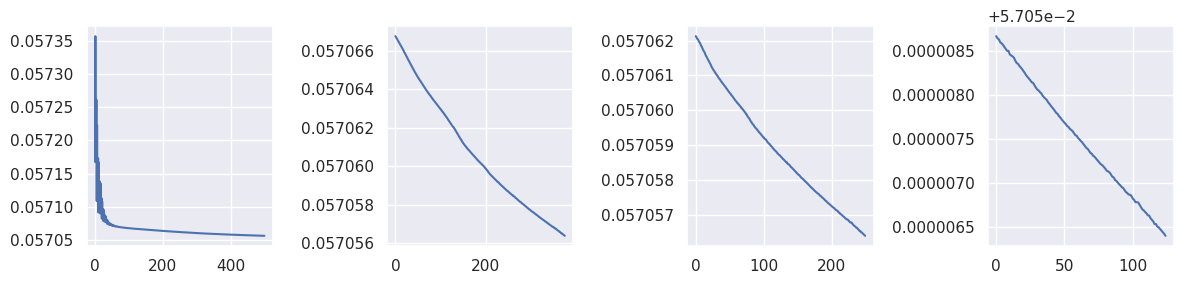

In [33]:
try:
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    for ax, beg in zip(axs, (0, 125, 250, 375)):
        ax.plot(([m.hedge_loss.item() for m in m_list][beg:]))
    plt.tight_layout()
    plt.show()
except:
    pass

## Evaluation

In [34]:
terminal_values_on_oos_test_set = np.sum(test_data.numpy(), axis=(1))[:, 0] + 1.0

In [35]:
dh_oosp = hedge_objective(deep_hedge(test_data[:2**15].cuda())).cpu().item()
rhgan_oosp = hedge_objective(robust_dh_gan.dh(test_data[:2**15].cuda())).cpu().item()
optimal_oosp = hedge_objective(optimal_hedge(test_data[:2**15].cuda())).cpu().item()

In [36]:
print(f'Optimal:          {optimal_oosp:.6f}')
print(f'Deep Hedge:       {dh_oosp:.6f}')
print(f'Robust Hedge GAN: {rhgan_oosp:.6f}')
print(f'--> improved by : {100*(1-rhgan_oosp/dh_oosp):.4f}%')

Optimal:          0.057056
Deep Hedge:       0.057168
Robust Hedge GAN: 0.057101
--> improved by : 0.1160%


In [37]:
no_to_display = 10000

In [38]:
@ray.remote
def generate(index, gen, number_of_paths):
    return index, gen(number_of_paths)

In [39]:
dh_oosp_for_ps_dict = {}
oh_oosp_for_ps_dict = {}
rhgan_oosp_for_ps_dict = {}
distances_to_estimate_dict = {}
for indices in tqdm(np.array_split(np.arange(no_to_display), np.arange(48,no_to_display,48))):
    for i, paths in ray.get([generate.remote(index=i, gen=test_generators[i], number_of_paths=no_to_display) for i in indices]):
        paths = paths.cuda()
        increments = torch.diff(paths, 1, 1)
        dh_oosp_for_ps_dict[i] = hedge_objective(deep_hedge(increments)).cpu().item()
        oh_oosp_for_ps_dict[i] = hedge_objective(optimal_hedge(increments)).cpu().item()
        rhgan_oosp_for_ps_dict[i] = hedge_objective(robust_dh_gan.dh(increments)).cpu().item() 
        distances_to_estimate_dict[i] = penalizer(paths[:, :, 0:2]).item()

In [40]:
dh_oosp_for_ps = [dh_oosp_for_ps_dict[i] for i in range(no_to_display)]
oh_oosp_for_ps = [oh_oosp_for_ps_dict[i] for i in range(no_to_display)]
rhgan_oosp_for_ps = [rhgan_oosp_for_ps_dict[i] for i in range(no_to_display)]
distances_to_estimate = [distances_to_estimate_dict[i] for i in range(no_to_display)]

In [41]:
print(f'                   Mean:       Std:')
print(f'Opt. Hedge:        {np.mean(oh_oosp_for_ps):.6f}    {np.std(oh_oosp_for_ps):.6f}')
print(f'Deep Hedge:        {np.mean(dh_oosp_for_ps):.6f}    {np.std(dh_oosp_for_ps):.6f}')
print(f'Robust Hedge GAN:  {np.mean(rhgan_oosp_for_ps):.6f}    {np.std(rhgan_oosp_for_ps):.6f}')

                   Mean:       Std:
Opt. Hedge:        0.055277    0.006862
Deep Hedge:        0.055359    0.007139
Robust Hedge GAN:  0.055284    0.006816


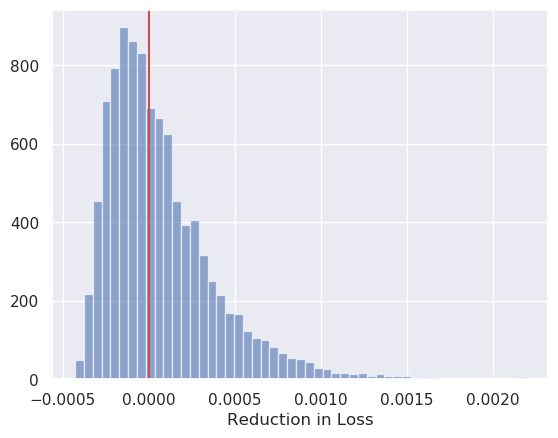

In [42]:
# plt.hist(dh_oosp_for_ps, bins=51)
plt.hist(- np.array(rhgan_oosp_for_ps) + np.array(dh_oosp_for_ps), bins=51, alpha=.6)
plt.axvline(0.0, c='r')
plt.xlabel('Reduction in Loss')
plt.show()

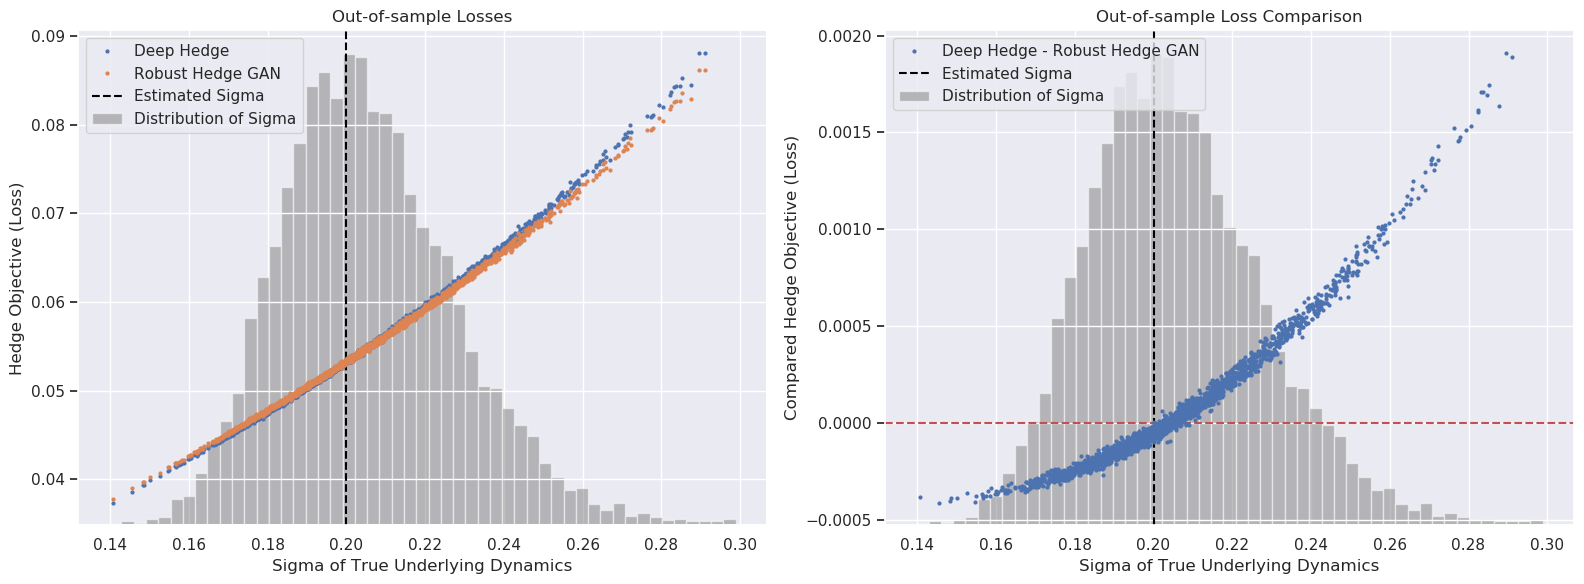

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
for_plot = 2000

ax0 = axs[0].twinx()
axs[0].grid(axis='y')
axs[0].hist(pars[:no_to_display], bins=51, alpha=.5, color='grey', label='Distribution of Sigma')
axs[0].get_yaxis().set_ticks([])
ax0.axvline(0.2, c='black', ls='--', label='Estimated Sigma')
ax0.plot(pars[:for_plot], np.array(dh_oosp_for_ps)[:for_plot], ls='', marker='.', label='Deep Hedge', ms=4)
ax0.plot(pars[:for_plot], np.array(rhgan_oosp_for_ps)[:for_plot], ls='', marker='.', label='Robust Hedge GAN', ms=4)
axs[0].set_xlabel('Sigma of True Underlying Dynamics')
ax0.set_ylabel('Hedge Objective (Loss)')
ax0.set_title('Out-of-sample Losses')
ax0.yaxis.tick_left()
ax0.yaxis.set_label_position("left")
# ax0.set_yscale('log')
lines, labels = ax0.get_legend_handles_labels()
lines2, labels2 = axs[0].get_legend_handles_labels()
ax0.legend(lines[1:] + lines[:1] + lines2, labels[1:] + labels[:1] + labels2, loc=2)

ax1 = axs[1].twinx()
axs[1].grid(axis='y')
axs[1].hist(pars[:no_to_display], bins=51, alpha=.5, color='grey', label='Distribution of Sigma')
axs[1].get_yaxis().set_ticks([])
ax1.axhline(0.0, c='C3', ls='--')
ax1.axvline(0.2, c='black', ls='--', label='Estimated Sigma')
ax1.plot(pars[:for_plot], np.array(dh_oosp_for_ps)[:for_plot] - np.array(rhgan_oosp_for_ps)[:for_plot], ls='', marker='.', ms=4, label='Deep Hedge - Robust Hedge GAN')
axs[1].set_xlabel('Sigma of True Underlying Dynamics')
ax1.set_ylabel('Compared Hedge Objective (Loss)')
ax1.set_title('Out-of-sample Loss Comparison')
ax1.yaxis.set_label_position("left")
ax1.yaxis.tick_left()
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = axs[1].get_legend_handles_labels()
ax1.legend(list(reversed(lines)) + lines2, list(reversed(labels)) + labels2, loc=2)

plt.tight_layout()
# plt.savefig(f'figs/oosp_bs/tf{trading_freq:02}_ps{penalty_scale:.0f}_pc{pars_coarseness}_ua{uncertainty_aversion:03}.pdf')
plt.show()

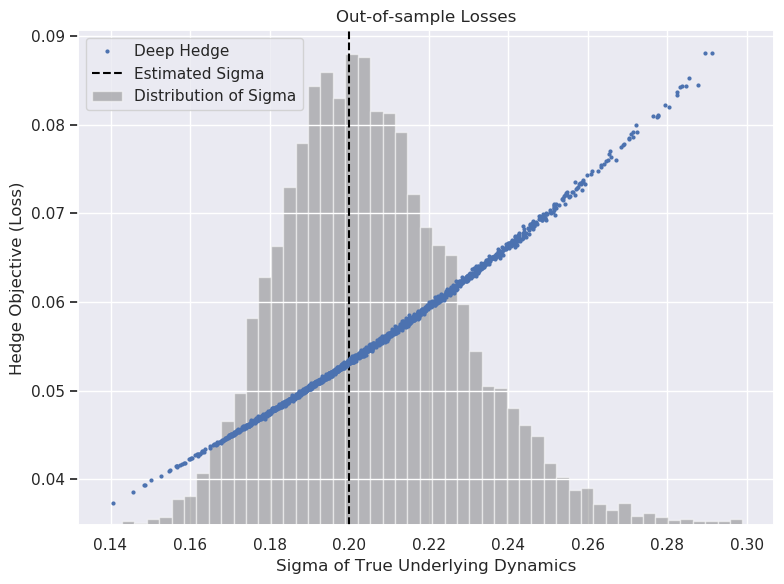

In [50]:
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
for_plot = 2000

ax0 = axs.twinx()
axs.grid(axis='y')
axs.hist(pars[:no_to_display], bins=51, alpha=.5, color='grey', label='Distribution of Sigma')
axs.get_yaxis().set_ticks([])
ax0.axvline(0.2, c='black', ls='--', label='Estimated Sigma')
ax0.plot(pars[:for_plot], np.array(dh_oosp_for_ps)[:for_plot], ls='', marker='.', label='Deep Hedge', ms=4)
axs.set_xlabel('Sigma of True Underlying Dynamics')
ax0.set_ylabel('Hedge Objective (Loss)')
ax0.set_title('Out-of-sample Losses')
ax0.yaxis.tick_left()
ax0.yaxis.set_label_position("left")
# ax0.set_yscale('log')
lines, labels = ax0.get_legend_handles_labels()
lines2, labels2 = axs.get_legend_handles_labels()
ax0.legend(lines[1:] + lines[:1] + lines2, labels[1:] + labels[:1] + labels2, loc=2)

plt.tight_layout()
# plt.savefig(f'figs/oosp_dh.pdf')
plt.show()